In [1]:
# Ideas generales
# Cargar ligandos_
# cocristalizados
# CSAR
# DUD
# DEKOIS

# Identificarlos como activos o inactivos

In [2]:
import pandas as pd
import numpy as np
from glob import glob
import os, pickle

from rdkit import Chem
from rdkit.Chem import AllChem

RDKit WARNING: [19:23:13] Enabling RDKit 2019.09.1 jupyter extensions


In [3]:
from rdkit import RDLogger 
RDLogger.DisableLog('rdApp.*')

In [4]:
def load_molecules_from_dir(list_of_sdf_files):
    '''Function to load molecules from sdf files using rdkit'''
    # Load the molecules in a dictionary
    mols_dict = {}
    sanitized = True
    for sdf_file in list_of_sdf_files:
        # Get the molecule name
        mol_name = sdf_file.split('/')[-1].split('.')[0]
        # Try to load the molecule with sanitize = True
        mol_rd = Chem.SDMolSupplier(sdf_file, sanitize = True)[0]
        if mol_rd is None:
            mol_rd = Chem.SDMolSupplier(sdf_file, sanitize = False)[0]
            mol_rd.UpdatePropertyCache(strict = False)
            sanitized = False
        mols_dict[mol_name] = [mol_rd, sanitized]
    return mols_dict

def get_files_list(path_to_sdfs, actives_name = 'ligand', inactives_name = 'decoy'):
    # Active molecules
    file_list_ACTIVES = glob(path_to_sdfs + F'/{actives_name}*')
    file_list_ACTIVES.sort(key = lambda x: 
                        int(x.split('/')[-1].split('.')[0].split('_')[1]) )
    # Inactive molecules
    file_list_INACTIVES = glob(path_to_sdfs + F'/{inactives_name}*')
    file_list_INACTIVES.sort(key = lambda x: 
                        int(x.split('/')[-1].split('.')[0].split('_')[1]) )
    # Join both list
    file_list = file_list_ACTIVES + file_list_INACTIVES
    return file_list

def get_mol_dataframe(mol_dictionary):
    # Convert to a dataframe
    df = pd.DataFrame(mol_dictionary).T
    df.columns = ['mol_rdk', 'sanitized']
    # Activity inactivity column
    act_inact = ['active' if i[:6] == 'ligand' else 'inactive' for i in df.index]
    df['Activity'] = act_inact
    # Naming the columns
    df = df[['Activity', 'mol_rdk', 'sanitized']]
    return df


## Cocristalized ligands
### Read the cocrystalized ligands
Previously, in notebook `1_Working_with_3D_structures_in_rdkit` we have saved a python object containing a dataframe with the cocristalized ligands. That dataframe is the following:

In [5]:
path_to_file_cocrys = os.path.join(*F'../data/rdkit_molecules/cdk2_365_cocristalized_ligands.pyobj'.split('/'))
with open(path_to_file_cocrys, 'rb') as f:
    df_crys_poses_rdk = pickle.load(f)
df_crys_poses_rdk.head()

,Lig,mol_rdk,file,Labels_conf,Validation
1aq1,STU,<rdkit.Chem.rdchem.Mol object at 0x7f73f2b17130>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_b,v1
1b38,ATP,<rdkit.Chem.rdchem.Mol object at 0x7f73f2b17170>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_a,v1
1b39,ATP,<rdkit.Chem.rdchem.Mol object at 0x7f73f2b171b0>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_a,v1
1ckp,PVB,<rdkit.Chem.rdchem.Mol object at 0x7f73f2b17230>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_a,v1
1di8,DTQ,<rdkit.Chem.rdchem.Mol object at 0x7f73f2b172b0>,../../ARCHIVOS/CRISTALES/LIGS_CDK2/POCKET_LIGS...,inact_a,v1


From this dataframe we are only interested in the ligand name, and in the `mol_rd` columns, which has the *rdkit* molecule instances. W also need to add column indicating that the ligand is an **Active**, or Inactive, ligand. Of course because these molecules were cocristalized with the protein we're going to assume all of them are actives.  

Also, we are going to remove duplicate ligands, mainly because for this analysis we are not interested in the 3D conformation. **At the end we only going to keep 315 ligands from the original 365**.

In [6]:
df_COCRYS = df_crys_poses_rdk.reset_index()[['Lig', 'mol_rdk']]
df_COCRYS.drop_duplicates(subset = 'Lig', inplace = True)
df_COCRYS.set_index('Lig', inplace = True)
df_COCRYS['Activity'] = 'active'
df_COCRYS['sanitized'] = True
df_COCRYS = df_COCRYS[['Activity', 'mol_rdk', 'sanitized']]
df_COCRYS.shape

(315, 3)

In [7]:
df_COCRYS.head()

,Activity,mol_rdk,sanitized
Lig,,,
STU,active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2b17130>,True
ATP,active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2b17170>,True
PVB,active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2b17230>,True
DTQ,active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2b172b0>,True
HMD,active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2b17330>,True


## CSAR dataset
### Read the CSAR dataset molecules

In [8]:
# Firs we got the molecules dictionary
path_to_file_csar_sdfs = \
os.path.join(*F'../../ARCHIVOS/CRISTALES/LIGS_CDK2/CSAR/sdf/*'.split('/'))
csar_file_list = glob(path_to_file_csar_sdfs)
# sort alphanumericalñy
csar_file_list.sort(key = lambda x: int(x.split('/')[-1].split('.')[0].replace('CS', '')))

# Load the molecules using the function previously declared
csar_molecules_dic = load_molecules_from_dir(csar_file_list)
# Convert to a dataframe
df_CSAR = pd.DataFrame(csar_molecules_dic).T
df_CSAR.columns = ['mol_rdk', 'sanitized']
# The information about if the molecule is active or inactive is in the following file
df_csar_activity = pd.read_json('../data/csar_Binding_Data_Corrected_2016.json')
# merge both dataframes
df_CSAR['Activity'] = df_csar_activity[['ActiveInactive']]
# Naming the columns
df_CSAR = df_CSAR[['Activity', 'mol_rdk', 'sanitized']]

In [9]:
df_CSAR.head()

,Activity,mol_rdk,sanitized
CS1,Active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2a9a4e0>,True
CS2,Active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2a9aa30>,True
CS3,Active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2a9aa80>,True
CS4,Active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2a9ab20>,True
CS5,Inactive,<rdkit.Chem.rdchem.Mol object at 0x7f73f2a9ab70>,True


In [10]:
len(df_CSAR[df_CSAR.sanitized == False])

99

## DUD 2006 Dataset

In [11]:
# Firs we got the molecules dictionary
path_to_file_dud_sdfs = \
os.path.join(*F'../../ARCHIVOS/CRISTALES/LIGS_CDK2/DUDE_DECOYS/DUD_2006/sdf/'.split('/'))
# Get the files list
dud_file_list = get_files_list(path_to_sdfs = path_to_file_dud_sdfs, 
                               actives_name='ligand', inactives_name='decoy')

# Load the molecules using the function previously declared
# load_molecules_from_dir(path_to_file_csar_sdfs)
dud_molecules_dic = load_molecules_from_dir(dud_file_list)

# Convert to a dataframe
df_DUD = get_mol_dataframe(mol_dictionary=dud_molecules_dic)

In [12]:
df_DUD.head()

,Activity,mol_rdk,sanitized
ligand_1,active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2a88e40>,True
ligand_2,active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2a88850>,True
ligand_3,active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2a88580>,True
ligand_4,active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2a88260>,True
ligand_5,active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2a88080>,True


In [13]:
len(df_DUD[df_DUD['sanitized'] == False])

2122

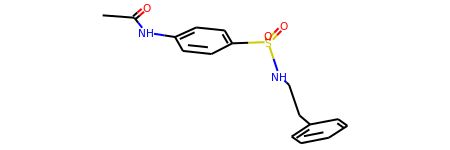

In [14]:
df_DUD.loc['decoy_29', 'mol_rdk']

## DEKOIS Dataset

In [15]:
# Firs we got the molecules dictionary
path_to_file_dekois_sdfs = \
os.path.join(*F'../../ARCHIVOS/CRISTALES/LIGS_CDK2/DEKOIS_2/sdf/'.split('/'))
# Get the files list
dekois_file_list = get_files_list(path_to_sdfs = path_to_file_dekois_sdfs, 
                               actives_name='ligand', inactives_name='decoy')

# Load the molecules using the function previously declared
# load_molecules_from_dir(path_to_file_csar_sdfs)
dekois_molecules_dic = load_molecules_from_dir(dekois_file_list)

# Convert to a dataframe
df_DEKOIS = get_mol_dataframe(mol_dictionary=dekois_molecules_dic)

In [16]:
df_DEKOIS.head()

,Activity,mol_rdk,sanitized
ligand_1,active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2aaf120>,True
ligand_2,active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2aaf440>,True
ligand_3,active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2aaf3f0>,True
ligand_4,active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2aaf4e0>,True
ligand_5,active,<rdkit.Chem.rdchem.Mol object at 0x7f73f2aaf5d0>,True


In [17]:
len(df_DEKOIS[df_DEKOIS['sanitized'] == False])

0

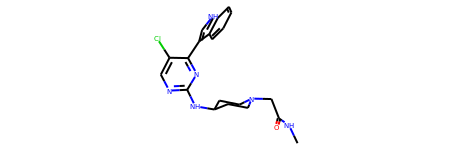

In [18]:
df_DEKOIS.loc['ligand_29', 'mol_rdk']